In [2]:
import pprint

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient

from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [3]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
col = db["india"]

In [4]:
col.find_one()

{'_id': ObjectId('67f54f743fc4bf1cdcc605cf'),
 'City': 'Ahmedabad',
 'Datetime': '1/1/2015 1:00',
 'PM2': '',
 'PM10': '',
 'NO': '1',
 'NO2': '40.01',
 'NOx': '36.37',
 'NH3': '',
 'CO': '1',
 'SO2': '122.07',
 'O3': '',
 'Benzene': '0',
 'Toluene': '0',
 'Xylene': '0',
 'AQI': '',
 'AQI_Bucket': ''}

In [5]:
def wrangle(collection):
    results = collection.find({
        "City": "Mumbai"
    }, projection = {
        "Datetime": 1, "PM2": 1, "_id": 0
    })
    
    df = pd.DataFrame(results).set_index("Datetime")
    
    # Filter to only data from 2020
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.year.isin(range(2015, 2020))]
    
    # Filter to Mumbai tz
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
    
    # Convert PM2 to floating point number
    df["PM2"] = df["PM2"].astype(float)
    
    # Remove outliers
    df = df[df["PM2"] < 140]
    
    # Drop all null values
    df.dropna(inplace=True)
    

    return df

In [6]:
df = wrangle(col)
df.head()

,PM2
Datetime,
2020-01-01 05:30:00+05:30,80.90
2020-01-01 06:30:00+05:30,88.78
2020-01-01 07:30:00+05:30,117.02
2020-01-01 08:30:00+05:30,127.49
2020-01-01 09:30:00+05:30,131.77


In [7]:
y = df["PM2"]

In [8]:
y.corr(y.shift(6))

0.7917214571501252

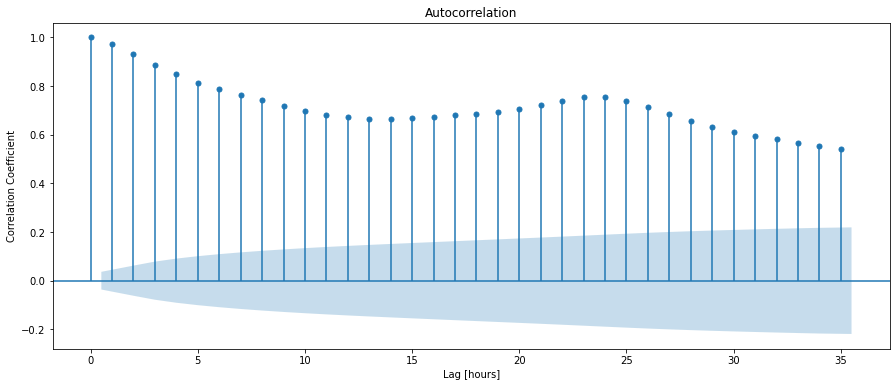

In [9]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

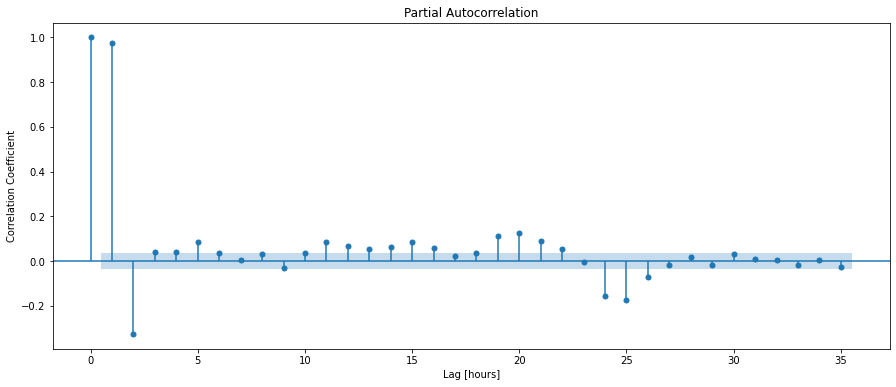

In [10]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [11]:
# train test split
cutoff = int(len(y) * 0.8)
y_train = y[:cutoff]
y_test = y[cutoff:]

In [12]:
# calculate baseline mae
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mae(y_train, y_pred_baseline)
baseline_mae

25.180203501724506

In [13]:
model = AutoReg(y_train, lags=26).fit()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [18]:
model.predict().dropna

Datetime
2020-01-01 05:30:00+05:30   NaN
2020-01-01 06:30:00+05:30   NaN
2020-01-01 07:30:00+05:30   NaN
2020-01-01 08:30:00+05:30   NaN
2020-01-01 09:30:00+05:30   NaN
                             ..
2020-04-06 21:30:00+05:30   NaN
2020-04-06 22:30:00+05:30   NaN
2020-04-06 23:30:00+05:30   NaN
2020-04-07 00:30:00+05:30   NaN
2020-04-07 01:30:00+05:30   NaN
Length: 2318, dtype: float64

In [16]:
y_test[0]

15.12